# Variance inflation factor (VIF)

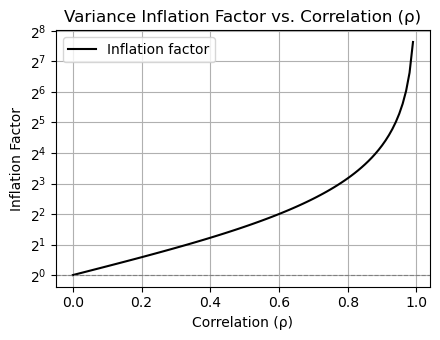

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Range of correlation values (rho)
rho_values = np.linspace(0, 0.99, 100)

# 1. Variance inflation factor: 1 + 2*rho / (1 - rho)
inflation_factors = 1 + 2 * rho_values / (1 - rho_values)

# 2. Effective number of trials for different values of n
n_values = [10, 30, 100]
n_eff_curves = {n: n * (1 - rho_values) / (1 + rho_values) for n in n_values}

# Plotting
fig, ax = plt.subplots(1, 1, figsize=(4.5, 3.5))

# Panel 1: Variance inflation factor
ax.plot(rho_values, inflation_factors, label='Inflation factor', color='black')
ax.set_title("Variance Inflation Factor vs. Correlation (ρ)")
ax.set_xlabel("Correlation (ρ)")
ax.set_ylabel("Inflation Factor")
ax.set_yscale('log', base=2)
ax.grid(True)
ax.axhline(1, color='gray', linestyle='--', linewidth=0.8)
ax.legend()

plt.tight_layout()
plt.show()

# iid and Correlation (VIF)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import binom

# Parameters
p = 0.5  # Probability of success for NT1
p_con = 0.02 # Probability of success for control
n_values = [2, 7, 14]
rho_values = [0.0, 0.3, 0.6, 0.9]  # Different correlation strengths
rho_values_con = [0.05, 0.05, 0.05, 0.05]

# Function to approximate variance inflation factor
def variance_inflation_factor(rho):
    return 1 + 2 * rho / (1 - rho + 1e-5)

# Create plot
fig, axes = plt.subplots(len(n_values), len(rho_values), figsize=(13, 8), sharey='row')

for i, n in enumerate(n_values):
    x = np.arange(0, n + 1)
    pmf_iid = binom.pmf(x, n, p)
    pmf_iid_con = binom.pmf(x, n, p_con)

    for j, rho in enumerate(rho_values):

        rho_con = rho_values_con[j]
        ax = axes[i, j]
        vif = variance_inflation_factor(rho)
        vif_con = variance_inflation_factor(rho_con)

        # Adjusted stddev using inflated variance
        std_iid = np.sqrt(n * p * (1 - p))
        std_corr = np.sqrt(vif) * std_iid
        # con
        std_iid_con = np.sqrt(n * p_con * (1 - p_con))
        std_corr_con = np.sqrt(vif_con) * std_iid_con

        # Approximate correlated distribution using Gaussian
        mu = n * p
        y_corr = np.exp(-0.5 * ((x - mu) / std_corr) ** 2)
        y_corr /= y_corr.sum()  # normalize

        mu_con = n * p_con
        y_corr_con = np.exp(-0.5 * ((x - mu_con) / std_corr_con) ** 2)
        y_corr_con /= y_corr_con.sum()

        #ax.bar(x, y_corr, width=0.4, label='', color='pink', alpha=0.5)
        ax.bar(x-0.2, pmf_iid, width=0.4, label='i.i.d.', color='red')
        ax.plot(x-0.2, y_corr, 'o--', color='darkred', label=f'ρ = {rho}')
        
        # controls
        # ax.bar(x, y_corr_con, width=0.4, label='', color='pink', alpha=0.5)
        ax.bar(x+0.2, pmf_iid_con, width=0.4, label='i.i.d.', color='skyblue')
        ax.plot(x+0.2, y_corr_con, 'o--', color='darkblue', label=f'ρ = {rho_con}')
        
        ax.set_title(f"n = {n}, ρ = {rho}")
        ax.set_xticks(x)
        if j == 0:
            ax.set_ylabel("Probability")
        if i == len(n_values) - 1:
            ax.set_xlabel("Positive test nights")
        if i == 0 and j == 0:
            ax.legend()

fig.suptitle("Impact of Correlation (ρ) on Distribution of Positive Nights for NT1", fontsize=14)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

In [ ]:
# Re-import necessary libraries after kernel reset
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import binom
import pandas as pd

# Parameters
p = 0.5  # Probability of success for NT1
p_con = 0.02  # Probability of success for control
n_values = [2, 7, 14]
rho_values = [0.0, 0.3, 0.6, 0.9]
rho_values_con = [0.05, 0.05, 0.05, 0.05]

# VIF calculation
def variance_inflation_factor(rho):
    return 1 + 2 * rho / (1 - rho + 1e-5)

# Compute approximate Gaussian approximation
def gaussian_approx(x, mu, std):
    y = np.exp(-0.5 * ((x - mu) / std) ** 2)
    return y / y.sum()

# Function to calculate classification metrics
def compute_metrics(y_nt1, y_con, threshold):
    TP = y_nt1[threshold:].sum()
    FN = y_nt1[:threshold].sum()
    FP = y_con[threshold:].sum()
    TN = y_con[:threshold].sum()

    sensitivity = TP / (TP + FN + 1e-8)
    specificity = TN / (TN + FP + 1e-8)
    precision = TP / (TP + FP + 1e-8)
    f1 = 2 * (precision * sensitivity) / (precision + sensitivity + 1e-8)
    fp_tp_ratio = FP / (TP + 1e-8)

    return sensitivity, specificity, fp_tp_ratio, f1

# Prepare figure and metric storage
fig, axes = plt.subplots(len(n_values), len(rho_values), figsize=(13, 8), sharey='row')
metrics = []

for i, n in enumerate(n_values):
    x = np.arange(0, n + 1)
    pmf_iid = binom.pmf(x, n, p)
    pmf_iid_con = binom.pmf(x, n, p_con)

    for j, (rho, rho_con) in enumerate(zip(rho_values, rho_values_con)):
        ax = axes[i, j]

        vif_nt1 = variance_inflation_factor(rho)
        vif_con = variance_inflation_factor(rho_con)

        std_nt1 = np.sqrt(n * p * (1 - p)) * np.sqrt(vif_nt1)
        std_con = np.sqrt(n * p_con * (1 - p_con)) * np.sqrt(vif_con)

        mu_nt1 = n * p
        mu_con = n * p_con

        y_nt1 = gaussian_approx(x, mu_nt1, std_nt1)
        y_con = gaussian_approx(x, mu_con, std_con)

        # Plot
        ax.bar(x - 0.2, pmf_iid, width=0.4, label='NT1 i.i.d.', color='red')
        ax.plot(x - 0.2, y_nt1, 'o--', color='darkred', label=f'NT1, ρ = {rho:.2f}')
        ax.bar(x + 0.2, pmf_iid_con, width=0.4, label='Control i.i.d.', color='skyblue')
        ax.plot(x + 0.2, y_con, 'o--', color='darkblue', label=f'Control, ρ = {rho_con:.2f}')

        # Classification threshold (e.g., at least 2 positives)
        threshold = 2
        sens, spec, ratio, f1 = compute_metrics(y_nt1, y_con, threshold)
        metrics.append({
            'n': n, 'rho': rho,
            'sensitivity': sens, 'specificity': spec,
            'fp_tp_ratio': ratio, 'f1': f1
        })

        ax.set_title(f"n={n}, ρ={rho}")
        ax.set_xticks(x)
        if j == 0:
            ax.set_ylabel("Probability")
        if i == len(n_values) - 1:
            ax.set_xlabel("Positive test nights")
        if i == 0 and j == 0:
            ax.legend()


fig.suptitle("Distributions & Metrics of Positive Test Nights (NT1 vs Controls)", fontsize=14)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

In [18]:
import numpy as np
from scipy.stats import binom

# Parameters
p = 0.5       # Probability of positive night for NT1
p_con = 0.02  # Probability for control
n_values = [2, 7, 14]
rho_values = [0.0, 0.3, 0.6, 0.9]
rho_values_con = [0.05, 0.05, 0.05, 0.05]

# Variance Inflation Factor function
def variance_inflation_factor(rho):
    return 1 + 2 * rho / (1 - rho + 1e-5)

# Gaussian approximation of correlated binomial-like distributions
def gaussian_approx(x, mu, sigma):
    y = np.exp(-0.5 * ((x - mu) / sigma) ** 2)
    return y / y.sum()

# Performance metrics with prevalence correction
def compute_metrics_with_prevalence(y_nt1, y_con, threshold, prevalence_ratio=1/200):
    prevalence_nt1 = prevalence_ratio
    prevalence_con = 1 - prevalence_ratio

    TP = y_nt1[threshold:].sum() * prevalence_nt1
    FN = y_nt1[:threshold].sum() * prevalence_nt1
    FP = y_con[threshold:].sum() * prevalence_con
    TN = y_con[:threshold].sum() * prevalence_con

    sensitivity = TP / (TP + FN + 1e-8)
    specificity = TN / (TN + FP + 1e-8)
    precision = TP / (TP + FP + 1e-8)
    f1 = 2 * (precision * sensitivity) / (precision + sensitivity + 1e-8)
    fp_tp_ratio = FP / (TP + 1e-8)

    return sensitivity, specificity, fp_tp_ratio, f1

# Run the simulation and collect metrics
metrics_with_prevalence = []

for i, n in enumerate(n_values):
    x = np.arange(0, n + 1)
    pmf_iid = binom.pmf(x, n, p)
    pmf_iid_con = binom.pmf(x, n, p_con)

    for j, (rho, rho_con) in enumerate(zip(rho_values, rho_values_con)):
        vif_nt1 = variance_inflation_factor(rho)
        vif_con = variance_inflation_factor(rho_con)

        std_nt1 = np.sqrt(n * p * (1 - p)) * np.sqrt(vif_nt1)
        std_con = np.sqrt(n * p_con * (1 - p_con)) * np.sqrt(vif_con)

        mu_nt1 = n * p
        mu_con = n * p_con

        y_nt1 = gaussian_approx(x, mu_nt1, std_nt1)
        y_con = gaussian_approx(x, mu_con, std_con)

        # Threshold for classifying NT1 (e.g., at least 2 positive nights)
        threshold = 2
        sens, spec, ratio, f1 = compute_metrics_with_prevalence(y_nt1, y_con, threshold)
        metrics_with_prevalence.append({
            'n': n, 'rho': rho,
            'sensitivity': sens, 'specificity': spec,
            'fp_tp_ratio': ratio, 'f1': f1
        })

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Load metrics into a DataFrame
df_metrics = pd.DataFrame(metrics_with_prevalence)

# Set up the seaborn style
sns.set(style="whitegrid")

# Plot performance metrics as a function of nights, hue by correlation
fig, axs = plt.subplots(2, 2, figsize=(12, 8))

sns.lineplot(ax=axs[0, 0], data=df_metrics, x="n", y="sensitivity", hue="rho", marker="o")
axs[0, 0].set_title("Sensitivity vs. Number of Nights")
axs[0, 0].set_ylabel("Sensitivity")

sns.lineplot(ax=axs[0, 1], data=df_metrics, x="n", y="specificity", hue="rho", marker="o")
axs[0, 1].set_title("Specificity vs. Number of Nights")
axs[0, 1].set_ylabel("Specificity")

sns.lineplot(ax=axs[1, 0], data=df_metrics, x="n", y="fp_tp_ratio", hue="rho", marker="o")
axs[1, 0].set_title("False Positives / True Positives")
axs[1, 0].set_ylabel("FP/TP Ratio")

sns.lineplot(ax=axs[1, 1], data=df_metrics, x="n", y="f1", hue="rho", marker="o")
axs[1, 1].set_title("F1 Score vs. Number of Nights")
axs[1, 1].set_ylabel("F1 Score")

for ax in axs.flat:
    ax.set_xlabel("Number of Nights")
    ax.legend(title="ρ (Correlation)")

plt.tight_layout()
plt.show()

In [15]:
metrics

[{'n': 2,
  'rho': 0.0,
  'sensitivity': np.float64(0.21194155549766994),
  'specificity': np.float64(0.9999999900000002),
  'fp_tp_ratio': np.float64(2.6794825849094665e-19),
  'f1': np.float64(0.34975540039648945)},
 {'n': 2,
  'rho': 0.3,
  'sensitivity': np.float64(0.2692967986307325),
  'specificity': np.float64(0.9999999900000002),
  'fp_tp_ratio': np.float64(2.1088023161394672e-19),
  'f1': np.float64(0.42432438918619403)},
 {'n': 2,
  'rho': 0.6,
  'sensitivity': np.float64(0.3045037812914804),
  'specificity': np.float64(0.9999999900000002),
  'fp_tp_ratio': np.float64(1.8649808311445625e-19),
  'f1': np.float64(0.4668499715984217)},
 {'n': 2,
  'rho': 0.9,
  'sensitivity': np.float64(0.32743443513202625),
  'specificity': np.float64(0.9999999900000002),
  'fp_tp_ratio': np.float64(1.734373833334708e-19),
  'f1': np.float64(0.49333424165106465)},
 {'n': 7,
  'rho': 0.0,
  'sensitivity': np.float64(0.9402092156956683),
  'specificity': np.float64(0.9999891421289637),
  'fp_tp_r

# Conway Maxwell Binomial

In [8]:
import lib.CMBD.ConwayMaxwellBinomial as cmb

p = 0.4
nu = 0.9
m = 100
com_distn = cmb.ConwayMaxwellBinomial(p, nu, m)

In [ ]:
# to sample from the distribution
com_distn.rvs(size=10)

array([39, 41, 41, 51, 28, 45, 34, 44, 34, 30])

In [10]:
# to evaluate PMF at some outcome 
com_distn.pmf(99)
com_distn.pmf(40)

np.float64(0.07544501942200499)

In [11]:
# To estmiate the parameters of the Conway Maxwell Binomial distribution given a sample
sample = com_distn.rvs(size=15)
initial_params = [0.5, 1]
cmb.estimateParams(m, sample, initial_params)

array([0.35951914, 1.14792391])

In [12]:
# To evaluate the negative log-likelihood of a sample
cmb.conwayMaxwellNegLogLike([p, nu], m, sample)

np.float64(44.590972780522975)

In [ ]:
# Re-import necessary packages after code execution state reset
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from scipy.special import comb, factorial
from scipy.stats import rv_discrete

# Conway-Maxwell-Binomial PMF (unnormalized)
def cmbd_unnorm_pmf(k, n, p, nu):
    binom_coeff = comb(n, k)
    prob_term = p**k * (1 - p)**(n - k)
    penalty_term = (factorial(k) * factorial(n - k))**(nu - 1)
    return binom_coeff * prob_term / penalty_term

# Normalize to get valid PMF
def cmbd_pmf(n, p, nu):
    pmf_vals = np.array([cmbd_unnorm_pmf(k, n, p, nu) for k in range(n + 1)])
    pmf_vals /= pmf_vals.sum()
    return pmf_vals

# Fit nu using empirical data
def fit_cmbd_nu(data, n, p):
    # Negative log likelihood
    def neg_ll(nu):
        pmf = cmbd_pmf(n, p, nu)
        log_probs = np.log(pmf[data])
        return -np.sum(log_probs)

    res = minimize(neg_ll, x0=[1.0], bounds=[(0.01, 5.0)])
    return res.x[0] if res.success else None

# Example NT1 2-night empirical data
nt1_data = np.array([1, 2, 2, 1, 0, 2, 2, 1, 2, 2, 0, 1, 1, 2, 1, 2, 2, 1, 0, 1, 2, 1, 2, 0, 2, 1, 1, 2])
n_nights = 2
empirical_p = nt1_data.sum() / (len(nt1_data) * n_nights)

# Fit CMBD parameter nu
estimated_nu = fit_cmbd_nu(nt1_data, n_nights, empirical_p)

# Get final PMF and sample from it
final_pmf = cmbd_pmf(n_nights, empirical_p, estimated_nu)
cmbd_rv = rv_discrete(name='cmbd', values=(np.arange(n_nights + 1), final_pmf))
samples = cmbd_rv.rvs(size=10000)

# Plot results
plt.figure(figsize=(6, 4))
plt.hist(samples, bins=np.arange(n_nights + 2) - 0.5, density=True, alpha=0.6, color='purple', label='Simulated CMBD')
plt.hist(nt1_data, bins=np.arange(n_nights + 2) - 0.5, density=True, alpha=0.6, color='gray', label='Empirical NT1')
plt.xticks(np.arange(n_nights + 1))
plt.xlabel("Positive Nights")
plt.ylabel("Probability")
plt.title(f"CMBD Simulation vs NT1 Data (ν ≈ {estimated_nu:.2f})")
plt.legend()
plt.tight_layout()
plt.show()